# Clustering de documents

## Imports

In [21]:
import collections
import os
import string
import sys
import re

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [22]:
import nltk

nltk.download('punkt')
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /Users/ilaria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ilaria/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
#check repertoire courant et son contenu
import os

print("Répertoire courant :", os.getcwd())
print("Contenu du dossier courant :", os.listdir())


Répertoire courant : /Users/ilaria/Desktop/STIC/traitement_auto_corpus/tac/tps/tp3
Contenu du dossier courant : ['s3_word_embeddings.ipynb', 'README.md', 's1_classification.ipynb', 's2_clustering.ipynb']


In [53]:
data_path = "../../data/txt/"


## Choisir une décennie

In [60]:
DECADE = '1950'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [61]:
import os
print(os.getcwd())


/Users/ilaria/Desktop/STIC/traitement_auto_corpus/tac/tps/tp3


In [62]:
# Lister tous les fichiers correspondant à la décennie
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE}" in f]
#decade moins le denrier caractere qui est 0 donc on a 199 etc...donc on contruit un corput avec les fichers de la decennei année 50

In [63]:
# Exemple de fichiers
files[:5]

['KB_JB838_1950-01-06_01-00002.txt',
 'KB_JB838_1950-01-07_01-00013.txt',
 'KB_JB838_1950-01-08_01-00011.txt',
 'KB_JB838_1950-01-10_01-00006.txt',
 'KB_JB838_1950-01-15_01-00010.txt']

In [64]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [65]:
# Exemple de textes
texts[0][:400]

'/ LE SOIR Une importante manifestation franco-belge Le Comité franco-belge du Commerce, de l’Industrie et de l’Agriculture qui. au cours de l’année écoulée et dans les circonstances les plus difficiles a rendu aux relations économiques entre les deux pays des services considérables, donnera le 12 janvier, à 19 h. 30, un dîner à l’occasion de l’anniversaire de son installation. Ce comité, qui fonct'

## Vectoriser les documents à l'aide de TF-IDF

In [77]:
# Création d'une fonction de pré-traitement, tokenization et suppression de la ponctuation
def preprocessing(text, stem=True):
    """ Tokenize text, remove punctuation, and remove French stopwords """
    # Supprimer la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Supprimer les stopwords français
    tokens = [t for t in tokens if t.lower() not in stopwords.words('french')]
    
    return tokens


### Instancier le modèle TF-IDF avec ses arguments

In [78]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [79]:
tfidf_vectors = vectorizer.fit_transform(texts)
#on recupere nos vecteurs sur les textes et on va trouevr la matrice

/Users/ilaria/Desktop/STIC/traitement_auto_corpus/tac/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [83]:
# Détail de la matrice
tfidf_vectors
# et vérifie le nombre de documents et de mots, numero documents 1000,  numeros mots 3506

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 77712 stored elements and shape (100, 4001)>

### Imprimer le vecteur tf-IDF du premier document

In [84]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)
#voir comment on petucalculer les distances entres les vecteurs pour s'entraine r et comprendre ce modele
#calculer l'angle des vecteus qui donne le cosinus, mêmes vecteurs la distance est 0; distance (0 veut dire qucoune distance ou 1)
#  et similarité (-1 à 1) donce les deux ne sont pas à confondre

parti           0.272563
consultation    0.187758
janvier         0.155746
loyer           0.143852
propriétaire    0.129467
                  ...   
huysmans        0.000000
hélas           0.000000
héros           0.000000
hôpital         0.000000
00              0.000000
Length: 4001, dtype: float64

## Comprendre les vecteurs et leurs "distances"

In [85]:
cosine([1, 2, 3], [1, 2, 3])

np.float64(0.0)

In [86]:
cosine([1, 2, 3], [1, 2, 2])

np.float64(0.02004211298777725)

In [87]:
cosine([1, 2, 3], [2, 2, 2])

np.float64(0.07417990022744858)

### Tests sur nos documents

In [88]:
tfidf_array = tfidf_vectors.toarray()

In [89]:
# Vecteur du document 0
tfidf_array[0]

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.03600753], shape=(4001,))

In [90]:
# Vecteur du document 1
tfidf_array[1]

array([0.00976808, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ], shape=(4001,))

In [91]:
cosine(tfidf_array[0], tfidf_array[1])

np.float64(0.9419637970313313)

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [108]:
N_CLUSTERS = 3

### Instancier le modèle K-Means et ses arguments

In [109]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [110]:
clusters = km_model.fit_predict(tfidf_vectors)
#fit_predic renvoye des clusters poru chaque document

In [103]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [111]:
pprint(dict(clustering))

{np.int32(0): ['KB_JB838_1950-01-07_01-00013.txt',
               'KB_JB838_1950-02-15_01-00014.txt',
               'KB_JB838_1950-02-18_01-00014.txt',
               'KB_JB838_1950-02-28_01-00012.txt',
               'KB_JB838_1950-03-03_01-00013.txt',
               'KB_JB838_1950-03-15_01-00012.txt',
               'KB_JB838_1950-04-25_01-00011.txt',
               'KB_JB838_1950-05-24_01-00014.txt',
               'KB_JB838_1950-06-14_01-00014.txt',
               'KB_JB838_1950-07-02_01-00018.txt',
               'KB_JB838_1950-11-24_01-00015.txt',
               'KB_JB838_1950-11-28_01-00012.txt',
               'KB_JB838_1950-11-29_01-00013.txt',
               'KB_JB838_1950-12-20_01-00013.txt',
               'KB_JB838_1950-12-24_01-00017.txt'],
 np.int32(1): ['KB_JB838_1950-01-08_01-00011.txt',
               'KB_JB838_1950-01-22_01-00014.txt',
               'KB_JB838_1950-02-15_01-00011.txt',
               'KB_JB838_1950-02-16_01-00014.txt',
               'KB_JB838_1950-

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [112]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [113]:
reduced_vectors[:10]

array([[-0.34659154,  0.14101763],
       [ 0.1696043 , -0.6983108 ],
       [ 0.37741237,  0.00224819],
       [-0.26950351, -0.03773153],
       [-0.0858138 , -0.03061266],
       [ 0.53845184,  0.38322348],
       [-0.26919873, -0.02343257],
       [-0.24313491, -0.0087892 ],
       [ 0.57441958,  0.35920216],
       [ 0.13104007, -0.09160694]])

### Générer le plot

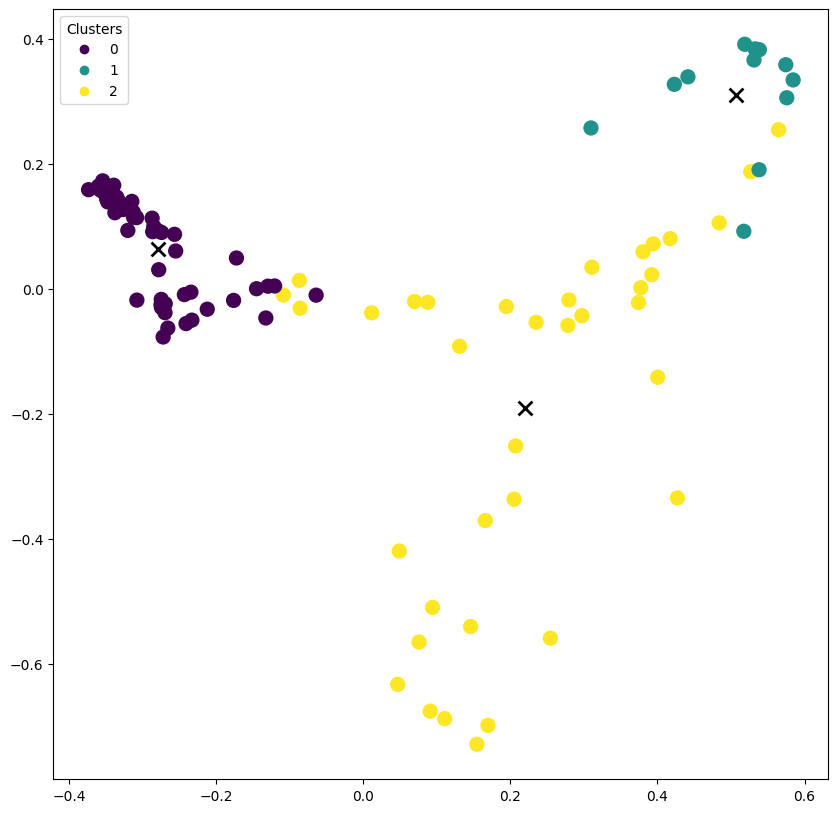

In [114]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

#par l'image: on se rend compte qu epeut êre 5 cluster etions trop et put etre meuilleur resultat en reduisant le clistur no pas à 5
#de manière iterative on peut voir si on peut organiser l'ensemble dans un ensemble plus coherent (exercice pour le tp)

## Analyse mots clef

In [118]:
top_keywords = 10
for cluster_id, docs in cluster_docs.items():
    all_text = " ".join(docs)
    frequencies = Counter(all_text.split())
    print(f"Cluster {cluster_id} :")
    print(frequencies.most_common(top_keywords))


Cluster 0 :
[('BRUXELLES', 384), ('RUE', 380), ('TRÈS', 321), ('ANS', 308), ('LEURS', 299), ('GRAND', 283), ('PEU', 280), ('LIEU', 277), ('BELGIQUE', 260), ('GRANDE', 257)]
Cluster 1 :
[('RUE', 530), ('TÉL', 417), ('ECRIRE', 379), ('ECR', 375), ('BRUXELLES', 328), ('BON', 322), ('ANS', 259), ('DEMANDE', 250), ('PRÉS', 234), ('BRUX', 202)]
Cluster 2 :
[('TÉL', 1721), ('RUE', 1122), ('BRUXELLES', 575), ('PRIX', 490), ('LOUER', 384), ('CONF', 383), ('MAISON', 358), ('BRUX', 355), ('ECR', 311), ('LIBRE', 307)]


## Nouage de mots

### Nettoyage des textes

In [119]:
from nltk.corpus import stopwords
import nltk
from collections import Counter

nltk.download('stopwords')
sw = stopwords.words("french")
sw += ["les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout",
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres",
       "van", "het", "autre", "jusqu", "ville", "rossel", "dem","etxc","elles","dés",
       "prixx", "écr", "géné", "app", "adr", "mod", "bur", "trav", "et", "de", "à", "en",
       "le", "la", "les", "du", "des", "aux", "un", "une"]
sw = set(sw)

def clean_text_string(text):
    words = nltk.wordpunct_tokenize(text)
    kept = [w.upper() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
    return " ".join(kept)

cleaned_texts = [clean_text_string(text) for text in texts]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilaria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Préparation des clusters pour WordCloud

In [120]:
import os

# Associer les textes nettoyés à chaque cluster
cluster_docs = {i: [] for i in range(N_CLUSTERS)}
for doc, label in zip(cleaned_texts, clusters):
    cluster_docs[label].append(doc)

# Créer un dossier pour les WordClouds
wc_path = "../../data/tmp_wordclouds/"
os.makedirs(wc_path, exist_ok=True)


### Génération et affichage des WordCloud + top keywords

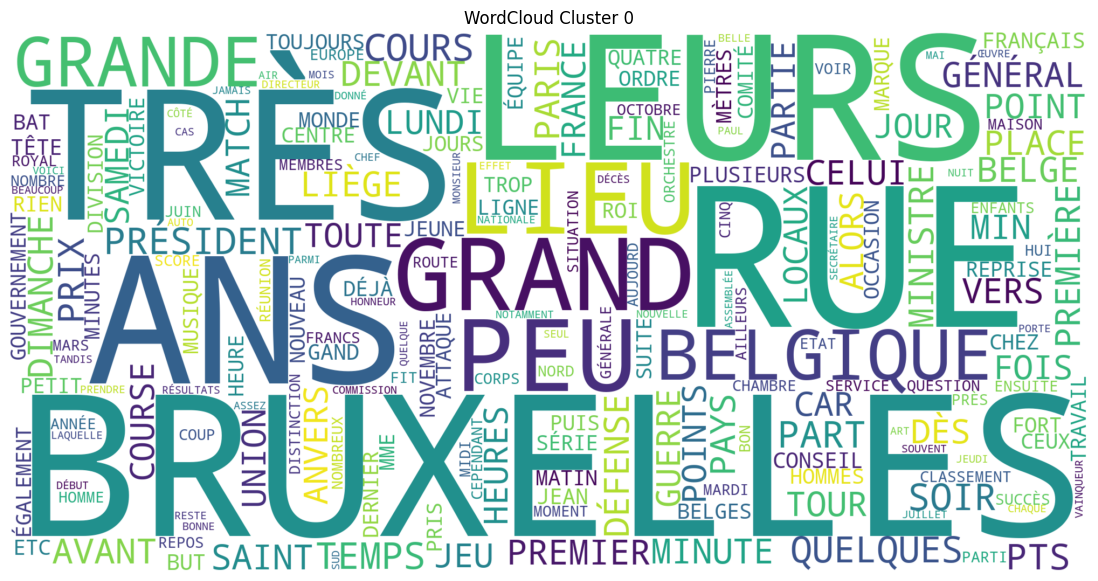

Cluster 0 - Top 10 mots :
[('BRUXELLES', 384), ('RUE', 380), ('TRÈS', 321), ('ANS', 308), ('LEURS', 299), ('GRAND', 283), ('PEU', 280), ('LIEU', 277), ('BELGIQUE', 260), ('GRANDE', 257)]

--------------------------------------------------



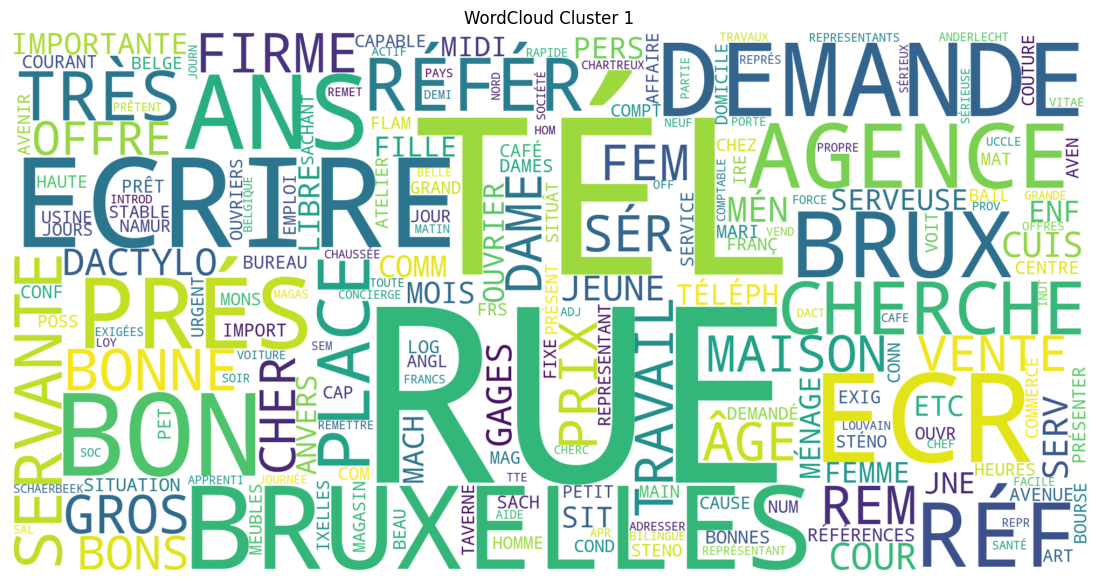

Cluster 1 - Top 10 mots :
[('RUE', 530), ('TÉL', 417), ('ECRIRE', 379), ('ECR', 375), ('BRUXELLES', 328), ('BON', 322), ('ANS', 259), ('DEMANDE', 250), ('PRÉS', 234), ('BRUX', 202)]

--------------------------------------------------



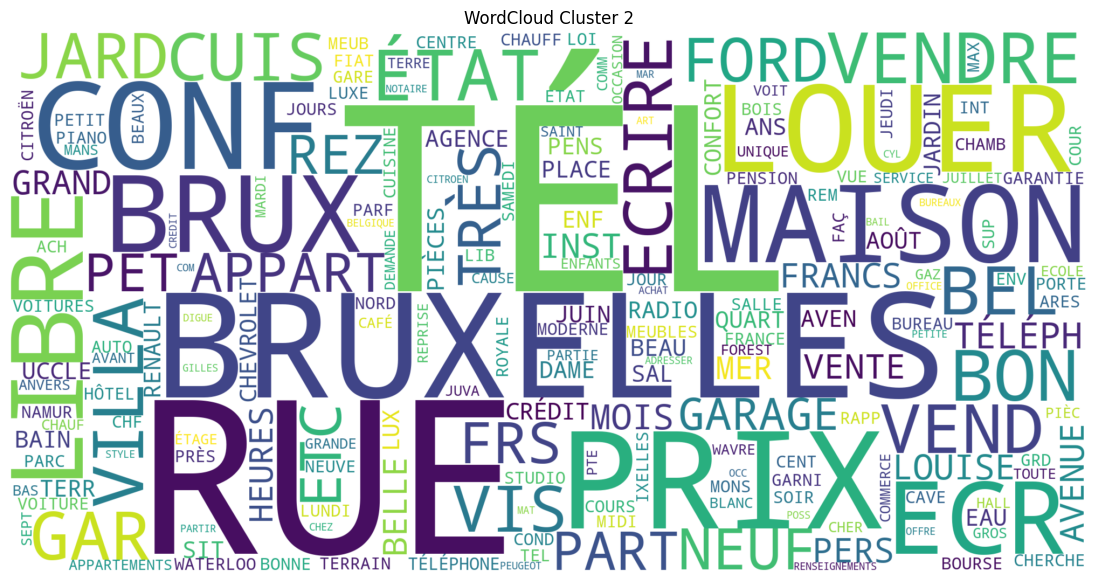

Cluster 2 - Top 10 mots :
[('TÉL', 1721), ('RUE', 1122), ('BRUXELLES', 575), ('PRIX', 490), ('LOUER', 384), ('CONF', 383), ('MAISON', 358), ('BRUX', 355), ('ECR', 311), ('LIBRE', 307)]

--------------------------------------------------



In [121]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

top_keywords = 10

for cluster_id, docs in cluster_docs.items():
    all_text = " ".join(docs)
    frequencies = Counter(all_text.split())
    
    # WordCloud
    cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
    file_name = os.path.join(wc_path, f"cluster_{cluster_id}.png")
    cloud.to_file(file_name)
    
    # Affichage dans le notebook
    plt.figure(figsize=(15,7))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud Cluster {cluster_id}")
    plt.show()
    
    # Affichage top keywords
    print(f"Cluster {cluster_id} - Top {top_keywords} mots :")
    print(frequencies.most_common(top_keywords))
    print("\n" + "-"*50 + "\n")
